# Actions on Articulated Agents (Habitat-Lab 레벨 Tutorial)

Configuration

In [1]:
import git, os
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

### 1. Interacting with Objects  
일단 Object가 올려져 있는 Scene을 업로드 해야 합니다.  
앞의 과정들은 함수화해서 한번에 실행할께요.

In [2]:
import git, os
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

In [3]:
from habitat.config.default_structured_configs import AgentConfig

# Agent config 정의
main_agent_config = AgentConfig()

urdf_path = os.path.join(data_path, "robots/hab_fetch/robots/hab_fetch.urdf")
main_agent_config.articulated_agent_urdf = urdf_path
main_agent_config.articulated_agent_type = "FetchRobot"

from habitat.config.default_structured_configs import ThirdRGBSensorConfig, HeadRGBSensorConfig, HeadDepthSensorConfig, HeadPanopticSensorConfig
# Agent Config 속 Sensor 정의
main_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
    "head_depth": HeadDepthSensorConfig(),
    "head_panoptic": HeadPanopticSensorConfig()
}

agent_dict = {"main_agent": main_agent_config}

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


In [4]:
import warnings
warnings.filterwarnings('ignore')
from omegaconf import OmegaConf

from habitat.config.default_structured_configs import SimulatorConfig
import habitat_sim
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim

from habitat_sim.physics import JointMotorSettings, MotionType
import magnum as mn

def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # This is for better graphics
    sim_cfg.habitat_sim_v0.enable_hbao = True
    sim_cfg.habitat_sim_v0.enable_physics = True
    
    # Set up an example scene
    sim_cfg.scene = os.path.join(data_path, "hssd-hab/scenes-partnr-filtered/102344022.scene_instance.json") # 진짜 그 scene을 정의하는 json
    sim_cfg.scene_dataset = os.path.join(data_path, "hssd-hab/hssd-hab-partnr.scene_dataset_config.json") # 이외에 scene load에 필요한 데이터셋들 경로 저장
    sim_cfg.additional_object_paths = [os.path.join(data_path, 'objects/ycb/configs/')] # 추가 objects 경로
    
    cfg = OmegaConf.create(sim_cfg)
    
    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    
    return cfg


def init_rearrange_sim(agent_dict):
    # Start the scene config
    sim_cfg = make_sim_cfg(agent_dict)    
    
    cfg = OmegaConf.create(sim_cfg)
    
    # Create the scene
    sim = RearrangeSim(cfg)
    
    # This is needed to initialize the agents
    sim.agents_mgr.on_new_scene()

    # For this tutorial, we will also add an extra camera that will be used for third person recording.
    camera_sensor_spec = habitat_sim.CameraSensorSpec()
    camera_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    camera_sensor_spec.uuid = "scene_camera_rgb"
    
    # TODO: this is a bit dirty but I think its nice as it shows how to modify a camera sensor...
    sim.add_sensor(camera_sensor_spec, 0)

    return sim

In [5]:
from habitat.datasets.rearrange.rearrange_dataset import RearrangeEpisode
import os
import gzip
import json


episode_file = os.path.join(data_path, "hab3_bench_assets/episode_datasets/small_large.json.gz")
sim = init_rearrange_sim(agent_dict)
# Load the dataset
with gzip.open(episode_file, "rt") as f: 
    episode_files = json.loads(f.read())

# Get the first episode
episode = episode_files["episodes"][0]
rearrange_episode = RearrangeEpisode(**episode)

art_agent = sim.articulated_agent
art_agent._fixed_base = True
sim.agents_mgr.on_new_scene()

sim.reconfigure(sim.habitat_config, ep_info=rearrange_episode)
sim.reset()

art_agent.sim_obj.motion_type = MotionType.KINEMATIC
init_pos = mn.Vector3(-5.5,0,-1.5)
sim.articulated_agent.base_pos =  init_pos 
_ = sim.step({})

Configuration(sim_cfg=<habitat_sim._ext.habitat_sim_bindings.SimulatorConfiguration object at 0x7f8626cfacf0>, agents=[AgentConfiguration(height=1.5, radius=0.1, sensor_specifications=[<habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f8626997c70>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f8626997cc0>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f8626997d60>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f8626997db0>], action_space={0: ActionSpec(name='stop', actuation=None), 1: ActionSpec(name='move_forward', actuation=ActuationSpec(amount=0.25, constraint=None)), 2: ActionSpec(name='turn_left', actuation=ActuationSpec(amount=10, constraint=None)), 3: ActionSpec(name='turn_right', actuation=ActuationSpec(amount=10, constraint=None))}, body_type='cylinder')], metadata_mediator=None, enable_batch_renderer=False)
/partnr-planner/data/hssd-hab/scenes-partnr-filtered/102344022.scene_instance.json

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[07:13:23:961247]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hssd-hab-partnr' : Lighting Layout Attributes '/partnr-planner/data/hssd-hab/scenes-partnr-filtered/102344022.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[07:13:24:513126]:[Warning]:[Sim] Simulator.cpp(599)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0
[07:13:26:673392]:[Warning]:[Metadata] SceneDatasetAttribute

Habitat-Sim의 RigidObjectManager를 통해 Scene에 어떤 Rigid objects이 있는지,  
ArticulatedObjectManager를 통해 어떤 Articulated objects(robot agent 의미)이 있는지 조회할 수 있습니다.

In [6]:
aom = sim.get_articulated_object_manager()
rom = sim.get_rigid_object_manager()

# We can query the articulated and rigid objects
print("List of articulated objects:")
for handle, ao in aom.get_objects_by_handle_substring().items():
    print(handle, "id", aom.get_object_id_by_handle(handle))

print("\nList of rigid objects:")
obj_ids = []
for handle, ro in rom.get_objects_by_handle_substring().items():
    if ro.awake:
        print(handle, "id", ro.object_id)
        obj_ids.append(ro.object_id)

List of articulated objects:
hab_fetch_:0000 id 83

List of rigid objects:
002_master_chef_can_:0000 id 109
002_master_chef_can_:0001 id 110
002_master_chef_can_:0002 id 111
002_master_chef_can_:0004 id 113
002_master_chef_can_:0003 id 112
004_sugar_box_:0000 id 114
007_tuna_fish_can_:0000 id 115
009_gelatin_box_:0000 id 116
010_potted_meat_can_:0000 id 117
024_bowl_:0000 id 118


지정한 물건의 위치를 구해 그곳으로 agent를 옮겨주고, 물건을 바라보도록 합니다  

002_master_chef_can_:0001 is in Vector(-5.54008, 0.66569, 0.13275)


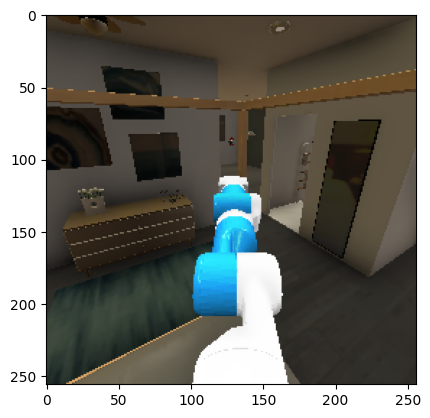

In [7]:
import matplotlib.pyplot as plt
import numpy as np

sim.reset()
art_agent.sim_obj.motion_type = MotionType.KINEMATIC
obj_id = sim.scene_obj_ids[1]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)

sample = sim.pathfinder.get_random_navigable_point_near(
    circle_center=object_trans, radius=1.0, island_index=-1
)
vec_sample_obj = object_trans - sample

angle_sample_obj = np.arctan2(-vec_sample_obj[2], vec_sample_obj[0])

sim.articulated_agent.base_pos = sample
sim.articulated_agent.base_rot = angle_sample_obj
obs = sim.step({})

plt.imshow(obs["head_rgb"])

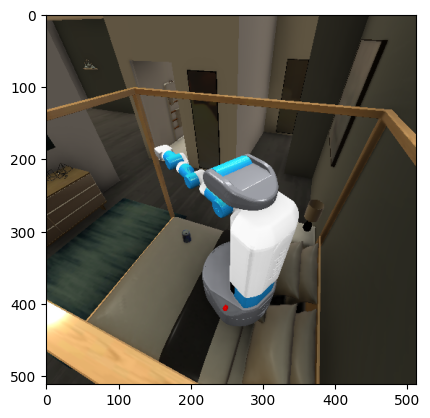

In [8]:
plt.imshow(obs['third_rgb'])

물건을 grasp하려면 grasp_manager을 사용합니다.  
sim 속 agent의 grasp_mgrs 속성을 사용하고, snap_to_obj method로 obj_id를 전달해 물건을 움켜쥡니다.   

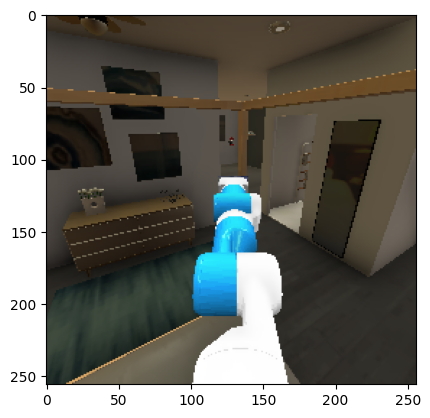

In [9]:
# We use a grasp manager to interact with the object:
agent_id = 0
grasp_manager = sim.agents_mgr[agent_id].grasp_mgrs[0]
grasp_manager.snap_to_obj(obj_id)
obs = sim.step({})
plt.imshow(obs["head_rgb"])

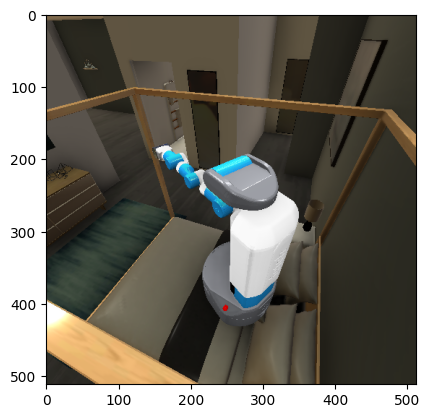

In [10]:
plt.imshow(obs['third_rgb'])

In [11]:
import habitat_sim.utils.viz_utils as vut

num_iter = 1

observations = []

sim.articulated_agent.base_pos = sample
for _ in range(num_iter):    
    forward_vec = art_agent.base_transformation.transform_vector(mn.Vector3(1,0,0))
    art_agent.base_pos = art_agent.base_pos + forward_vec * 0.02
    observations.append(sim.step({}))
    
# Remove the object
grasp_manager.desnap()
for _ in range(100):
    observations.append(sim.step({}))
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)


Encoding the video: robot_tutorial_video.mp4 


물건을 집은 상태에서 또 다른 물건을 집으려고 하면 에러가 발생합니다.  

002_master_chef_can_:0001 is in Vector(-5.54008, 0.66569, 0.13275)
002_master_chef_can_:0003 is in Vector(-5.63847, 0.624561, -5.80458)


ValueError: Tried snapping to 112 when already snapped to 110

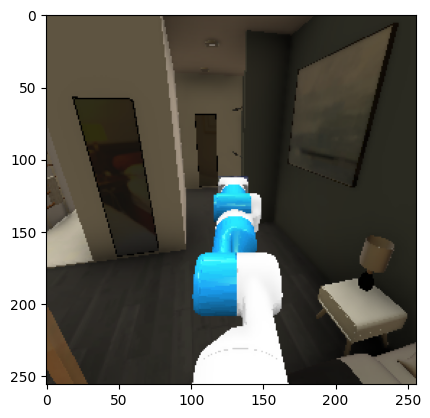

In [12]:
sim.reset()
art_agent.sim_obj.motion_type = MotionType.KINEMATIC
obj_id = sim.scene_obj_ids[1]
obj2_id = sim.scene_obj_ids[3]
first_object = rom.get_object_by_id(obj_id)
second_object = rom.get_object_by_id(obj2_id)

object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)

sample = sim.pathfinder.get_random_navigable_point_near(
    circle_center=object_trans, radius=1.0, island_index=-1
)
vec_sample_obj = object_trans - sample

angle_sample_obj = np.arctan2(-vec_sample_obj[2], vec_sample_obj[0])

sim.articulated_agent.base_pos = sample
sim.articulated_agent.base_rot = angle_sample_obj
obs = sim.step({})

agent_id = 0
grasp_manager = sim.agents_mgr[agent_id].grasp_mgrs[0]
grasp_manager.snap_to_obj(obj_id)
obs = sim.step({})
plt.imshow(obs["head_rgb"])

obj2_id = sim.scene_obj_ids[3]
second_object = rom.get_object_by_id(obj2_id)
object_trans = second_object.translation
print(second_object.handle, "is in", object_trans)

sample = sim.pathfinder.get_random_navigable_point_near(
    circle_center=object_trans, radius=1.0, island_index=-1
)
vec_sample_obj = object_trans - sample

angle_sample_obj = np.arctan2(-vec_sample_obj[2], vec_sample_obj[0])

sim.articulated_agent.base_pos = sample
sim.articulated_agent.base_rot = angle_sample_obj
grasp_manager = sim.agents_mgr[agent_id].grasp_mgrs[0]
grasp_manager.snap_to_obj(obj2_id)
obs = sim.step({})


force option을 주거나, desnap을 해야 잡을 수 있습니다.

### 2. Defining Agent action  


지금까지 우리는 로봇의 매개변수를 직접 업데이트하여 에이전트를 제어해왔습니다. 많은 경우, 로봇을 업데이트하는 동작으로 상호작용을 추상화하고 싶을 수 있습니다. 이러한 동작은 계획자나 학습된 정책에 의해 호출될 수 있습니다. 이 섹션에서는 이러한 동작을 정의하고 에이전트를 제어하는 방법을 보여드리겠습니다. Habitat Quickstart는 동작을 추가하는 방법에 대한 더 많은 지침을 제공합니다: Habitat Quickstart.
TODO: 기술 튜토리얼을 가리키기
동작을 실행하기 위해, 우리는 Env를 사용할 것입니다. Env는 시뮬레이터 인스턴스와 동작 정의 및 지정 가능한 보상을 포함하는 객체입니다. 우리는 지정 가능한 보상에 대해서는 다루지 않을 것입니다.


So far, we have been controlling agents by directly updating the robot parameters. In  many cases, you may want to abstract interaction into actions that update the robot. These actions can then be called by a planner or a learned policy. In this section we will show how to define and control agents with these actions. The Habitat Quickstart provides more instructions into how to add actions https://aihabitat.org/docs/habitat-lab/quickstart.html.
TODO: point to skills tutorial

To execute actions, we will be using the `Env`, which is an object that contains a simulator instance as well as a set of action definitions and specifiable rewards. We will not be going through the specifiable rewards. 

In [13]:
from habitat.config.default_structured_configs import TaskConfig, EnvironmentConfig, DatasetConfig, HabitatConfig
from habitat.config.default_structured_configs import ArmActionConfig, BaseVelocityActionConfig, OracleNavActionConfig, ActionConfig
from habitat.core.env import Env
def make_sim_cfg(agent_dict):
    # Start the scene config
    sim_cfg = SimulatorConfig(type="RearrangeSim-v0")
    
    # Enable Horizon Based Ambient Occlusion (HBAO) to approximate shadows.
    sim_cfg.habitat_sim_v0.enable_hbao = True    
    sim_cfg.habitat_sim_v0.enable_physics = True

    # Set up an example scene
    sim_cfg.scene = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json")
    sim_cfg.scene_dataset = os.path.join(data_path, "hab3_bench_assets/hab3-hssd/hab3-hssd.scene_dataset_config.json")
    sim_cfg.additional_object_paths = [os.path.join(data_path, 'objects/ycb/configs/')]
    
    cfg = OmegaConf.create(sim_cfg)

    # Set the scene agents
    cfg.agents = agent_dict
    cfg.agents_order = list(cfg.agents.keys())
    return cfg

def make_hab_cfg(agent_dict, action_dict):
    sim_cfg = make_sim_cfg(agent_dict)
    task_cfg = TaskConfig(type="RearrangeEmptyTask-v0")
    task_cfg.actions = action_dict
    env_cfg = EnvironmentConfig()
    dataset_cfg = DatasetConfig(type="RearrangeDataset-v0", data_path="data/hab3_bench_assets/episode_datasets/small_large.json.gz")
    
    hab_cfg = HabitatConfig()
    hab_cfg.environment = env_cfg
    hab_cfg.task = task_cfg
    hab_cfg.dataset = dataset_cfg
    hab_cfg.simulator = sim_cfg
    hab_cfg.simulator.seed = hab_cfg.seed

    return hab_cfg

def init_rearrange_env(agent_dict, action_dict):
    hab_cfg = make_hab_cfg(agent_dict, action_dict)
    res_cfg = OmegaConf.create(hab_cfg)
    return Env(res_cfg)

DatasetConfig 때문에, data/scene_datasets에 경로 옮겨줘야 함  
-> symbolic link 걸어줘야 함

In [14]:
!ln -s /data/hab3_bench_assets/hab3-hssd/scenes data/scene_datasets

Agent가 수행할 수 있는 action을 넣어줍니다.  
아래와 같이 정의해줄 수 있습니다.  
또한, 아까와는 다른 점은 environment를 만든 다는 점

In [15]:
action_dict = {
    "oracle_magic_grasp_action": ArmActionConfig(type="MagicGraspAction"),
    "base_velocity_action": BaseVelocityActionConfig(),
    "oracle_coord_action": OracleNavActionConfig(type="OracleNavCoordinateAction", spawn_max_dist_to_obj=1.0)
}
env = init_rearrange_env(agent_dict, action_dict)

2025-01-21 07:13:59,039 Initializing dataset RearrangeDataset-v0
2025-01-21 07:13:59,046 initializing sim RearrangeSim-v0


getting simulator...
got simulator!
making sim...
Configuration(sim_cfg=<habitat_sim._ext.habitat_sim_bindings.SimulatorConfiguration object at 0x7f85f1592170>, agents=[AgentConfiguration(height=1.5, radius=0.1, sensor_specifications=[<habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f877e4d0a40>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f877e4d0900>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f877e4d09f0>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f877e4d0a90>], action_space={0: ActionSpec(name='stop', actuation=None), 1: ActionSpec(name='move_forward', actuation=ActuationSpec(amount=0.25, constraint=None)), 2: ActionSpec(name='turn_left', actuation=ActuationSpec(amount=10, constraint=None)), 3: ActionSpec(name='turn_right', actuation=ActuationSpec(amount=10, constraint=None))}, body_type='cylinder')], metadata_mediator=None, enable_batch_renderer=False)
data/hab3_bench_assets/hab3-hssd

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[07:13:59:282995]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[07:13:59:283132]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File `../hssd-hab_semantic_lexicon.json` does not exist.  Aborting load.
[07:13:59:283151]:[Warning]:[Scene] SemanticScene.cpp(121)::l

made sim!


RearrangeSim(config=Configuration(sim_cfg=<habitat_sim._ext.habitat_sim_bindings.SimulatorConfiguration object at 0x7f85f1592170>, agents=[AgentConfiguration(height=1.5, radius=0.1, sensor_specifications=[<habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f877e4d0a40>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f877e4d0900>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f877e4d09f0>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f877e4d0a90>], action_space={0: ActionSpec(name='stop', actuation=None), 1: ActionSpec(name='move_forward', actuation=ActuationSpec(amount=0.25, constraint=None)), 2: ActionSpec(name='turn_left', actuation=ActuationSpec(amount=10, constraint=None)), 3: ActionSpec(name='turn_right', actuation=ActuationSpec(amount=10, constraint=None))}, body_type='cylinder')], metadata_mediator=None, enable_batch_renderer=False), agents=[Agent(agent_config=AgentConfiguration(height=1.5, rad

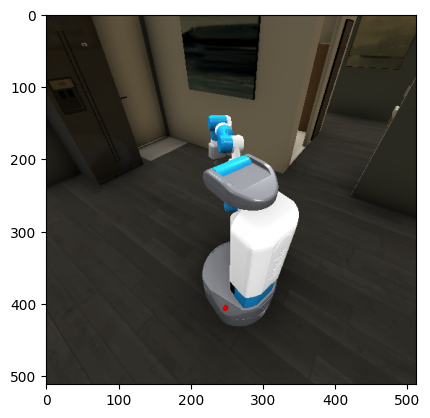

In [23]:
# The environment contains a pointer to an habitat simulator, which allows us to reproduce the steps we did before
print(env._sim)
# We can query the actions available, and their action space:
for action_name, action_space in env.action_space.items():
    print(action_name, action_space)
# Let's get an observation as before:
env.reset()
obs = env.step({"action": (), "action_args": {}})
plt.imshow(obs["third_rgb"])

base velocity action을 수행해보겠습니다.

In [ ]:
# We can now call the defined actions
observations = []
num_iter = 500
for _ in range(num_iter):
    params = env.action_space["base_velocity_action"].sample()
    action_dict = {
        "action": "base_velocity_action",
        "action_args": params
    }
    observations.append(env.step(action_dict))
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

이제, 물건을 지정하고, 물건을 향해 oracle하게 navigation하는 oracle_coord_action을 수행해보겠습니다.  
코드는 아래와 같이, agent - object 간 거리가 작아질때까지 수행합니다.  
아까 kinematic하게 좌표를 옮겨주었던 것과는 다르게 env.step(action)을 통해 수행합니다.

In [25]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)

# print(sample)
observations = []
delta = 2.0

object_agent_vec = env.sim.articulated_agent.base_pos - object_trans
object_agent_vec.y = 0
dist_agent_object = object_agent_vec.length()
# Walk towards the object

agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.articulated_agent.base_rot
prev_pos = env.sim.articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.articulated_agent.base_rot
    prev_pos = env.sim.articulated_agent.base_pos
    action_dict = {
        "action": ("oracle_coord_action"), 
        "action_args": {
              "oracle_nav_lookat_action": object_trans,
              "mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.articulated_agent.base_rot
    cur_pos = env.sim.articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)

# Wait
for _ in range(20):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))    
    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

002_master_chef_can_:0000 is in Vector(-5.51803, 0.71985, 0.94042)
Encoding the video: robot_tutorial_video.mp4 


이외에도 우리가 직접 정의할 수도 있습니다.

In [26]:
from habitat.tasks.rearrange.actions.articulated_agent_action import ArticulatedAgentAction
from habitat.core.registry import registry
from gym import spaces


@registry.register_task_action
class PickObjIdAction(ArticulatedAgentAction):
    
    @property
    def action_space(self):
        MAX_OBJ_ID = 1000
        return spaces.Dict({
            f"{self._action_arg_prefix}pick_obj_id": spaces.Discrete(MAX_OBJ_ID)
        })

    def step(self, *args, **kwargs):
        obj_id = kwargs[f"{self._action_arg_prefix}pick_obj_id"]
        print(self.cur_grasp_mgr, obj_id)
        self.cur_grasp_mgr.snap_to_obj(obj_id)

action_dict = {
    "pick_obj_id_action": ActionConfig(type="PickObjIdAction"),
    "base_velocity_action": BaseVelocityActionConfig(),
    "oracle_coord_action": OracleNavActionConfig(type="OracleNavCoordinateAction", spawn_max_dist_to_obj=1.0)
}
env = init_rearrange_env(agent_dict, action_dict)

2025-01-21 07:23:36,639 Initializing dataset RearrangeDataset-v0
2025-01-21 07:23:36,646 initializing sim RearrangeSim-v0


getting simulator...
got simulator!
making sim...
Configuration(sim_cfg=<habitat_sim._ext.habitat_sim_bindings.SimulatorConfiguration object at 0x7f877123fef0>, agents=[AgentConfiguration(height=1.5, radius=0.1, sensor_specifications=[<habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f856bf50950>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f856bf50900>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f856bf50540>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f856bf50450>], action_space={0: ActionSpec(name='stop', actuation=None), 1: ActionSpec(name='move_forward', actuation=ActuationSpec(amount=0.25, constraint=None)), 2: ActionSpec(name='turn_left', actuation=ActuationSpec(amount=10, constraint=None)), 3: ActionSpec(name='turn_right', actuation=ActuationSpec(amount=10, constraint=None))}, body_type='cylinder')], metadata_mediator=None, enable_batch_renderer=False)
data/hab3_bench_assets/hab3-hssd

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[07:23:37:144012]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'hab3-hssd' : Lighting Layout Attributes 'data/hab3_bench_assets/hab3-hssd/scenes/103997919_171031233.scene_instance.json' specified in Scene Attributes but does not exist in dataset, so creating default.
[07:23:37:144157]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File `../hssd-hab_semantic_lexicon.json` does not exist.  Aborting load.
[07:23:37:144176]:[Warning]:[Scene] SemanticScene.cpp(121)::l

made sim!


In [27]:
env.reset()
rom = env.sim.get_rigid_object_manager()
# env.sim.articulated_agent.base_pos = init_pos
# As before, we get a navigation point next to an object id

obj_id = env.sim.scene_obj_ids[0]
first_object = rom.get_object_by_id(obj_id)

object_trans = first_object.translation
print(first_object.handle, "is in", object_trans)

observations = []
delta = 2.0

object_agent_vec = env.sim.articulated_agent.base_pos - object_trans
object_agent_vec.y = 0
dist_agent_object = object_agent_vec.length()
# Walk towards the object

agent_displ = np.inf
agent_rot = np.inf
prev_rot = env.sim.articulated_agent.base_rot
prev_pos = env.sim.articulated_agent.base_pos
while agent_displ > 1e-9 or agent_rot > 1e-9:
    prev_rot = env.sim.articulated_agent.base_rot
    prev_pos = env.sim.articulated_agent.base_pos
    action_dict = {
        "action": ("oracle_coord_action"), 
        "action_args": {
              "oracle_nav_lookat_action": object_trans,
              "mode": 1
          }
    }
    observations.append(env.step(action_dict))
    
    cur_rot = env.sim.articulated_agent.base_rot
    cur_pos = env.sim.articulated_agent.base_pos
    agent_displ = (cur_pos - prev_pos).length()
    agent_rot = np.abs(cur_rot - prev_rot)
    # print(agent_rot, agent_displ)

for _ in range(20):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))    

action_dict = {"action": ("pick_obj_id_action"), "action_args": {"pick_obj_id": obj_id}}
observations.append(env.step(action_dict))
for _ in range(100):
    action_dict = {"action": (), "action_args": {}}
    observations.append(env.step(action_dict))    
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

003_cracker_box_:0000 is in Vector(-5.55847, 0.95434, -2.40326)
<habitat.tasks.rearrange.rearrange_grasp_manager.RearrangeGraspManager object at 0x7f856bf52fd0> 109
Encoding the video: robot_tutorial_video.mp4 


## ActionConfig 뭐뭐있나

1. HabitatBaseConfig  
2. ActionConfig  
3. ...

### ActionConfig
- ActionConfig
    - StopActionConfig
    - EmptyActionConfig
    - DiscreteNavigationActionConfig
        - MoveForwardActionConfig
        - TurnLeftActionConfig
        - TurnRightActionConfig
        - LookUpActionConfig
        - LookDownActionConfig
    - TeleportActionConfig
    - VelocityControlActionConfig
    - ArmActionConfig
    - BaseVelocityActionConfig
    - BaseVelocityNonCylinderActionConfig
    - HumanoidJointActionConfig
    - HumanoidPickActionConfig
    - RearrangeStopActionConfig
    - PddlApplyActionConfig
    - OracleNavActionConfig
    - SelectBaseOrArmActionConfig
    - AnswerActionConfig